In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.dummy import DummyRegressor
# from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from matplotlib import pyplot as plt
import seaborn as sn
# import xgboost
# from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import MinMaxScaler
# from fpdf import FPDF
# from datetime import datetime

# pdf = FPDF()
pdf_reports = dict()

In [125]:
dataset = pd.read_csv('dataset.csv', index_col=0)

dataset.head()

,date,symbol,econ_branch,score,year,month,day,close,roi_month,roi_quarter,roi_halfyear,roi_year
0,2004-02-11,SU,Energy Minerals,0.953727,2004,2,11,13.285000,0.015807,-0.085058,0.048927,0.406473
1,2004-02-11,GGG,Producer Manufacturing,0.952753,2004,2,11,9.388889,-0.048047,-0.010888,0.087811,0.348402
2,2004-02-11,CWT,Utilities,0.934181,2004,2,11,14.720000,-0.002717,-0.068954,-0.070992,0.178668
3,2004-02-11,BLL,Process Industries,0.922862,2004,2,11,8.095000,0.006640,-0.023935,0.124923,0.361334
4,2004-02-11,APA,Energy Minerals,0.912117,2004,2,11,39.830002,0.008034,0.025860,0.082350,0.442882


<AxesSubplot:>

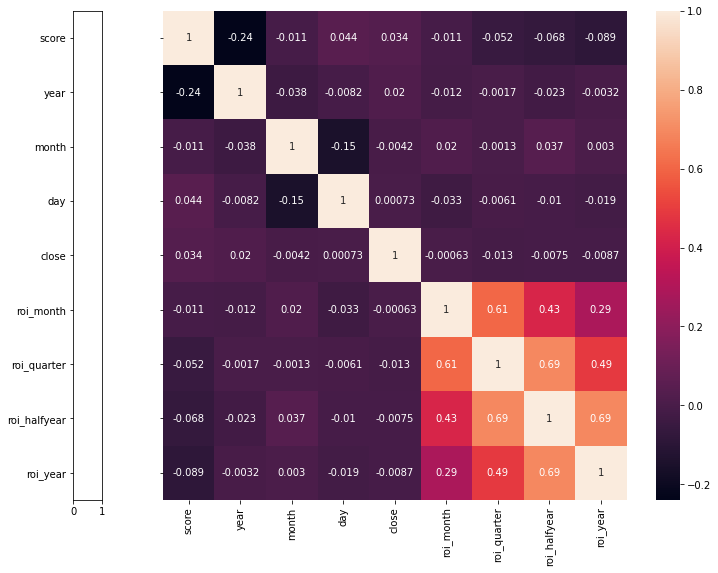

In [126]:

fig, ax = plt.subplots(1,2, figsize=(12, 9), sharey=True, gridspec_kw={'width_ratios': [1, 20]})
sn.heatmap(dataset.corr(), annot=True)

The heatmap of correlations shows, that roi values aren't linearly correlated with any variable in our dataset.

In [127]:
X = dataset[['score', 'symbol', 'close', 'year', 'econ_branch']]
y = dataset.iloc[:, -4:]

In [128]:
X, y

(          score symbol        close  year             econ_branch
 0      0.953727     SU    13.285000  2004         Energy Minerals
 1      0.952753    GGG     9.388889  2004  Producer Manufacturing
 2      0.934181    CWT    14.720000  2004               Utilities
 3      0.922862    BLL     8.095000  2004      Process Industries
 4      0.912117    APA    39.830002  2004         Energy Minerals
 ...         ...    ...          ...   ...                     ...
 10405  0.657795    RPM    90.209999  2021      Process Industries
 10406  0.651998    AZO  1423.270020  2021            Retail Trade
 10407  0.650983   QRVO   193.690002  2021   Electronic Technology
 10408  0.646593    PHM    53.529999  2021       Consumer Durables
 10409  0.636897    SCI    51.610001  2021       Consumer Services
 
 [10410 rows x 5 columns],
        roi_month  roi_quarter  roi_halfyear  roi_year
 0       0.015807    -0.085058      0.048927  0.406473
 1      -0.048047    -0.010888      0.087811  0.348402
 2

In [124]:
dummies1 = pd.get_dummies(X[['econ_branch']], drop_first=True)
dummies2 = pd.get_dummies(X[['econ_branch']], drop_first=True)
X = pd.concat([X.drop(['econ_branch'],axis=1), dummies],axis=1)
X

,score,symbol,close,year,econ_branch_Communications,econ_branch_Consumer Durables,econ_branch_Consumer Non-Durables,econ_branch_Consumer Services,econ_branch_Distribution Services,econ_branch_Electronic Technology,...,econ_branch_Health Services,econ_branch_Health Technology,econ_branch_Industrial Services,econ_branch_Non-Energy Minerals,econ_branch_Process Industries,econ_branch_Producer Manufacturing,econ_branch_Retail Trade,econ_branch_Technology Services,econ_branch_Transportation,econ_branch_Utilities
0,0.953727,SU,13.285000,2004,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.952753,GGG,9.388889,2004,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0.934181,CWT,14.720000,2004,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.922862,BLL,8.095000,2004,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0.912117,APA,39.830002,2004,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10405,0.657795,RPM,90.209999,2021,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
10406,0.651998,AZO,1423.270020,2021,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10407,0.650983,QRVO,193.690002,2021,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10408,0.646593,PHM,53.529999,2021,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We've chosen 4 variables as input for the models.
* score - the conviction score
* close - the closing price
* year - the year of the data point
* econ_branch - the name of the branch of the company. this variable is split into 18 binary dummy variables.

We split the data into train and test with proportions 0.67 - 0.33

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [130]:
def calculate_errors_for_train_test_split(model, X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.DataFrame, y_test: pd.DataFrame): # y_train and y_test should be only one column
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    errors_report = ["1. Mean squared error: %.2f" % mean_squared_error(y_test, y_pred)]
    errors_report.append("2. Mean absolute percentage error: %.2f" % mean_absolute_percentage_error(y_test, y_pred))
    errors_report.append("3. R^2: %.2f" % r2_score(y_test, y_pred))
    print(errors_report)
    return errors_report

In [131]:
def calculate_errors_for_cross_validation(model, X: pd.DataFrame, y: pd.DataFrame): # y should be only one column
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    mae = abs(cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)).mean()
    mape = abs(cross_val_score(model, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)).mean()
    r2 = abs(cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)).mean()
    errors_report = ["1. Mean squared error: %.2f" % mae]
    errors_report.append("2. Mean absolute percentage error: %.2f" % mape)
    errors_report.append("3. R^2: %.2f" % r2)
    print(errors_report)
    return errors_report

In [132]:
y

,roi_month,roi_quarter,roi_halfyear,roi_year
0,0.015807,-0.085058,0.048927,0.406473
1,-0.048047,-0.010888,0.087811,0.348402
2,-0.002717,-0.068954,-0.070992,0.178668
3,0.006640,-0.023935,0.124923,0.361334
4,0.008034,0.025860,0.082350,0.442882
...,...,...,...,...
10405,0.080479,0.007538,-0.115397,-0.042013
10406,0.058970,0.088543,0.183001,0.514533
10407,-0.049099,-0.008725,-0.146420,-0.409830
10408,0.153185,0.029516,-0.109658,-0.248085


In [107]:
for roi in ['roi_month', 'roi_quarter', 'roi_halfyear', 'roi_year']:

    dummy_regr = DummyRegressor(strategy="mean")
    pdf_reports['dummy_train_test'] = calculate_errors_for_train_test_split(dummy_regr, X_train, X_test, y_train[roi].to_frame(), y_test[roi].to_frame())

    dummy_regr = DummyRegressor(strategy="mean")
    pdf_reports['dummy_cross_validate'] = calculate_errors_for_cross_validation(dummy_regr, X, y[roi].to_frame())

    lin_regr = LinearRegression()
    pdf_reports['lin_regr_train_test'] = calculate_errors_for_train_test_split(lin_regr, X_train, X_test, y_train[roi].to_frame(), y_test[roi].to_frame())

    lin_regr = LinearRegression()
    pdf_reports['lin_regr_cross_validate'] = calculate_errors_for_cross_validation(lin_regr, X, y[roi].to_frame())

['1. Mean squared error: 0.01', '2. Mean absolute percentage error: 246363940402.32', '3. R^2: -0.00']
['1. Mean squared error: 0.06', '2. Mean absolute percentage error: 279477149765.40', '3. R^2: 0.00']
['1. Mean squared error: 0.01', '2. Mean absolute percentage error: 235917907372.29', '3. R^2: 0.00']
['1. Mean squared error: 0.06', '2. Mean absolute percentage error: 291491207293.53', '3. R^2: 0.00']
['1. Mean squared error: 0.02', '2. Mean absolute percentage error: 163322025532.92', '3. R^2: -0.00']
['1. Mean squared error: 0.10', '2. Mean absolute percentage error: 253215086857.09', '3. R^2: 0.00']
['1. Mean squared error: 0.02', '2. Mean absolute percentage error: 166503753145.32', '3. R^2: 0.00']
['1. Mean squared error: 0.10', '2. Mean absolute percentage error: 202136145490.01', '3. R^2: 0.01']
['1. Mean squared error: 0.04', '2. Mean absolute percentage error: 442720016741.64', '3. R^2: -0.00']
['1. Mean squared error: 0.15', '2. Mean absolute percentage error: 20689934948

In [108]:
pdf.output('reports/Errors_report.pdf')   

''

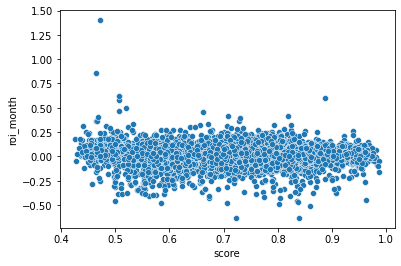

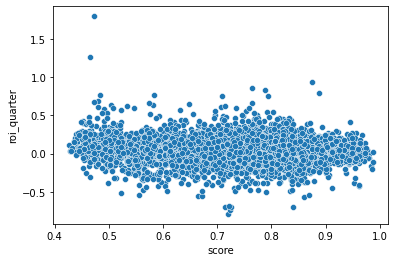

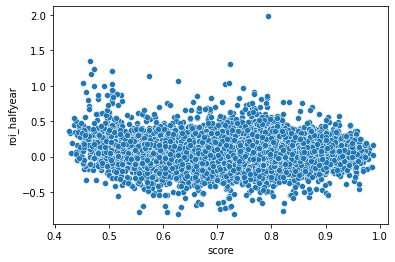

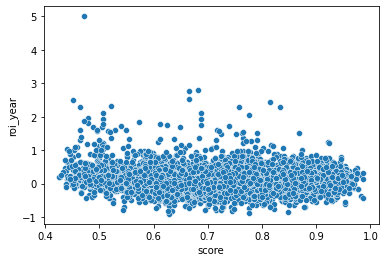

In [133]:
for roi in ['roi_month', 'roi_quarter', 'roi_halfyear', 'roi_year']:
    sn.scatterplot(x=X_train.score, y=y_train[roi])
    plt.show()

In [134]:
y

,roi_month,roi_quarter,roi_halfyear,roi_year
0,0.015807,-0.085058,0.048927,0.406473
1,-0.048047,-0.010888,0.087811,0.348402
2,-0.002717,-0.068954,-0.070992,0.178668
3,0.006640,-0.023935,0.124923,0.361334
4,0.008034,0.025860,0.082350,0.442882
...,...,...,...,...
10405,0.080479,0.007538,-0.115397,-0.042013
10406,0.058970,0.088543,0.183001,0.514533
10407,-0.049099,-0.008725,-0.146420,-0.409830
10408,0.153185,0.029516,-0.109658,-0.248085


In [135]:
X["const"] = 1.0
X

C:\Users\Jacek\AppData\Local\Temp\ipykernel_6840\1825498712.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["const"] = 1.0


,score,symbol,close,year,econ_branch,const
0,0.953727,SU,13.285000,2004,Energy Minerals,1.0
1,0.952753,GGG,9.388889,2004,Producer Manufacturing,1.0
2,0.934181,CWT,14.720000,2004,Utilities,1.0
3,0.922862,BLL,8.095000,2004,Process Industries,1.0
4,0.912117,APA,39.830002,2004,Energy Minerals,1.0
...,...,...,...,...,...,...
10405,0.657795,RPM,90.209999,2021,Process Industries,1.0
10406,0.651998,AZO,1423.270020,2021,Retail Trade,1.0
10407,0.650983,QRVO,193.690002,2021,Electronic Technology,1.0
10408,0.646593,PHM,53.529999,2021,Consumer Durables,1.0


In [54]:
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf

for roi in ['roi_month', 'roi_quarter', 'roi_halfyear', 'roi_year']:
    ols_data = X
    ols_data["roi"] = y[roi]
    model = smf.ols('roi ~ score + close + year', data=ols_data).fit()
    names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
    test = sms.het_breuschpagan(model.resid, model.model.exog)

    print(test)
print(names)

(136.8577611724773, 1.798575997317748e-29, 46.20922627347732, 1.1728770262401472e-29)
(69.10347564178464, 6.640710819337497e-15, 23.179510784665492, 5.99628234194038e-15)
(140.6569570495461, 2.7277581955180644e-30, 47.50957255123, 1.7350253033513322e-30)
(110.84716726797807, 7.211275514558168e-24, 37.332378734578754, 5.472051878603403e-24)
['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']


All p-values are well below 0.05, data isn't homoscedastic for any investment horizon

In [63]:
y_train

,roi_month,roi_quarter,roi_halfyear,roi_year
3033,0.008192,-0.015862,0.079310,0.221022
8734,-0.044041,0.126943,0.093523,0.273057
4049,0.007254,0.077720,0.104663,0.006477
7283,0.004914,-0.008980,-0.027279,-0.225178
5265,-0.037806,-0.105114,-0.107080,-0.090253
...,...,...,...,...
5734,0.039870,0.094914,-0.023964,0.210339
5191,0.043577,0.055833,-0.064458,-0.137994
5390,0.085159,0.169285,0.255064,0.247830
860,-0.039411,-0.042682,-0.031889,-0.102208


In [136]:
X_train.shape, y_train.shape

((6974, 5), (6974, 4))

In [137]:
#https://towardsdatascience.com/how-to-convert-pandas-dataframe-to-keras-rnn-and-back-to-pandas-for-multivariate-regression-dcc34c991df9

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.sequence import TimeseriesGenerator

In [138]:
Xscaler = MinMaxScaler(feature_range=(0, 1)) # scale so that all the X data will range from 0 to 1
Xscaler.fit(X_train)
scaled_X_train = Xscaler.transform(X_train)
scaled_X_train[:10]

ValueError: could not convert string to float: 'MCD'

In [139]:
y_train_month = np.array(y_train["roi_month"])
y_train_month

array([ 0.00819246, -0.04404137,  0.00725395, ...,  0.08515913,
       -0.03941128, -0.05017008])

In [144]:
input_size = 100

generator = TimeseriesGenerator(X_train, y_train_month, length=input_size, batch_size=32)

generator[0][0].shape

(32, 100, 5)

In [141]:
# Z MOODLE:
# model = keras.Sequential()
# model.add(layers.Embedding(input_dim=1000, output_dim=64))
# # The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
# model.add(layers.SimpleRNN(128))
# model.add(layers.Dense(10))
# model.summary()

In [142]:
n_features= X_train.shape[1]


model = keras.Sequential()
model.add(layers.GRU(10, activation='relu', input_shape=(input_size, n_features)))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 10)                510       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 521
Trainable params: 521
Non-trainable params: 0
_________________________________________________________________


In [143]:
model.fit(generator,epochs=5)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [113]:
scaled_X_test = Xscaler.transform(X_test)
test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=input_size, batch_size=32)

y_hat = model.predict(test_generator)
results = pd.DataFrame({'y_true':y_test["roi_month"].values[input_size:],'y_hat':y_hat.ravel()})

105/105 [==============================] - 9s 85ms/step


In [114]:
results

,y_true,y_hat
0,-0.092093,0.013874
1,0.041624,0.037702
2,-0.067656,0.009923
3,0.019404,0.003701
4,-0.165370,0.002349
...,...,...
3331,0.157895,0.024512
3332,0.006912,0.027216
3333,0.014252,0.009327
3334,0.051224,0.013901


In [115]:
print("1. Mean squared error: %.2f" % mean_squared_error(results["y_true"], results["y_hat"]))
print("2. Mean absolute percentage error: %.2f" % mean_absolute_percentage_error(results["y_true"], results["y_hat"]))
print("3. R^2: %.2f" % r2_score(results["y_true"], results["y_hat"]))

1. Mean squared error: 0.01
2. Mean absolute percentage error: 384693541401.13
3. R^2: -0.02


<AxesSubplot:>

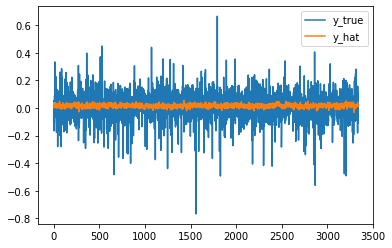

In [116]:
results.plot()

In [117]:
y_hat = model.predict(generator)
train_preds = pd.DataFrame({'y_true':y_train["roi_month"].values[input_size:],'y_hat':y_hat.ravel()})

215/215 [==============================] - 17s 81ms/step


In [118]:
print("1. Mean squared error: %.2f" % mean_squared_error(train_preds["y_true"], train_preds["y_hat"]))
print("2. Mean absolute percentage error: %.2f" % mean_absolute_percentage_error(train_preds["y_true"], train_preds["y_hat"]))
print("3. R^2: %.2f" % r2_score(train_preds["y_true"], train_preds["y_hat"]))

1. Mean squared error: 0.01
2. Mean absolute percentage error: 334696213916.07
3. R^2: -0.01


<AxesSubplot:>

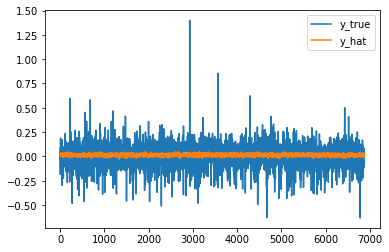

In [119]:
train_preds.plot()